In [51]:
# Get an image dataset
# Featurize this dataset so you can use any ML technique, as opposed to fancy CNN-based techniques specific to image tasks
# Embed the feature representations to a 2d space so you can visualize the data
# Cluster the data points, either after step (2) or step (3)
# Select points with lowest cluster probabilities as outliers
# Plot the clustering, with the outliers highlighted
# Display images corresponding to some of these outliers


#Outlier Visualization Abstract Base Class

In [1]:
import abc

In [2]:

class OutlierVisualization(metaclass = abc.ABCMeta):
  @abc.abstractmethod
  def featurize(self):
    pass

  @abc.abstractmethod
  def getEmbedding_PCA(self):
    pass
  @abc.abstractmethod
  def getEmbedding_UMAP(self):
    pass

  @abc.abstractmethod
  def visualize(self):
    pass

  @abc.abstractmethod
  def kmeans_clustering(self):
    pass
  
  @abc.abstractmethod
  def kmeans_clustering(self):
    pass
    
  @abc.abstractmethod
  def kmeans_cluster_plot(self):
    pass

  @abc.abstractmethod
  def outliers_inliers_plot_kmeans(self):
    pass


  @abc.abstractmethod
  def hdbscan_clustering(self):
    pass




In [12]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
from hdbscan.flat import (HDBSCAN_flat,
                          approximate_predict_flat,
                          membership_vector_flat,
                          all_points_membership_vectors_flat)

#MakeBlobs

In [55]:
class MakeBlobs_Outliers_Visualization(OutlierVisualization):
  
  def __init__(self,sample_count=1000, center_cnt=5, feature_count=2, rnd_state=2):
    self.num_classes = center_cnt;
    self.X, self.y = make_blobs(n_samples=sample_count, centers = center_cnt, n_features=feature_count, random_state=rnd_state)
    

  
  def featurize(self):
    self.X_features  = self.X;

  
  def getEmbedding_PCA(self, component_cnt=2):
    if len(self.X_features[0])==2:
      self.X_embedding_PCA =self.X_features;

    else:   

      pca = PCA(n_components=component_cnt)
      self.X_embedding_PCA = pca.fit_transform(self.X_features)



  
  def getEmbedding_UMAP(self):
    reducer = umap.UMAP()
    self.X_embedding_UMAP = reducer.fit_transform(self.X_features)


  def visualize(self, PCA=False, UMAP=True):


    if PCA:
      scatter_classes_mnist = plt.scatter(self.X_embedding_PCA [:, 0], self.X_embedding_PCA [:, 1], c=self.y)
      plt.legend(*scatter_classes_mnist.legend_elements(),
                      loc="upper right", title="Classes")
      plt.title("Plot using embeddings generated after PCA")
      plt.show()

    print()
    if UMAP:
      scatter_classes = plt.scatter(self.X_embedding_UMAP [:, 0], self.X_embedding_UMAP [:, 1], c=self.y)
      plt.legend(*scatter_classes.legend_elements(),
                      loc="upper right", title="Classes")
      plt.title("Plot using embeddings generated after UMAP")
      plt.show()


  def __goodness_score_point(self, cluster_dist_list , cluster_id , n):
    dist_from_assigned_cluster = cluster_dist_list[cluster_id];

    denominator  = sum([(1/a)** (n-1) for a in cluster_dist_list])
    numerator = (1/dist_from_assigned_cluster)** (n-1)

    return numerator / denominator;


  

  def goodness_score_kmeans(self):
    self.kmeans_goodness_score = [self.__goodness_score_point(self.kmeans_dist_from_cluster_centroid[i],\
                                                            self.kmeans.labels_[i] , self.cluster_count ) \
                      for i in list(range(0,len(self.kmeans.labels_)))]



  def kmeans_clustering(self,cluster_cnt=None, emdedding_choice_flag=True):
    
    if cluster_cnt==None:
      self.cluster_count=self.num_classes
    else:
      self.cluster_count=cluster_cnt



    self.embedding_choice = emdedding_choice_flag;

    if emdedding_choice_flag: #use umap embedding 
      self.kmeans= KMeans(n_clusters= self.cluster_count, random_state=0).fit(self.X_embedding_UMAP)
      self.kmeans_dist_from_cluster_centroid= self.kmeans.transform(self.X_embedding_UMAP);


    else:
      self.kmeans= KMeans(n_clusters= self.cluster_count, random_state=0).fit(self.X_embedding_PCA)
      self.kmeans_dist_from_cluster_centroid= self.kmeans.transform(self.X_embedding_PCA);



    
  def kmeans_cluster_plot(self):

    if self.embedding_choice: #use umap embedding 
      scatter_cluster = plt.scatter(self.X_embedding_UMAP[:, 0], self.X_embedding_UMAP[:, 1], c=self.kmeans.labels_)
      plt.scatter(self.kmeans.cluster_centers_[:, 0], \
                  self.kmeans.cluster_centers_[:, 1], s=30, c='blue', label = 'Centroids')
      plt.legend(*scatter_cluster.legend_elements(),loc="upper right", title="Clusters")
      plt.title("Kmeans cluster for UMAP embedding")
      plt.show()
          
          
    else:
      scatter_cluster = plt.scatter(self.X_embedding_PCA[:, 0], self.X_embedding_PCA[:, 1], c=self.kmeans.labels_)
      plt.scatter(self.kmeans.cluster_centers_[:, 0], \
                  self.kmeans.cluster_centers_[:, 1], s=30, c='blue', label = 'Centroids')
      plt.legend(*scatter_cluster.legend_elements(),loc="upper right", title="Clusters")
      plt.title("Kmeans cluster for PCA embedding")
      plt.show()


  def outliers_inliers_plot_kmeans(self, thrh = 0.7):

    goodness_score = np.array(self.kmeans_goodness_score)

    mask_outliers = (goodness_score < thrh) 
    mask_inliers= ~mask_outliers
    if self.embedding_choice: #use umap embedding 
      plt.scatter(self.X_embedding_UMAP[mask_inliers, 0], self.X_embedding_UMAP[mask_inliers, 1], c='g', label='inliers')
      plt.scatter(self.X_embedding_UMAP[mask_outliers, 0], self.X_embedding_UMAP[mask_outliers, 1], c='r', label='outliers')
      plt.legend()
      plt.title("Outlier visualization for UMAP embedding")
      plt.show()

    else:
      plt.scatter(self.X_embedding_PCA[mask_inliers, 0], self.X_embedding_PCA[mask_inliers, 1], c='g', label='inliers')
      plt.scatter(self.X_embedding_PCA[mask_outliers, 0], self.X_embedding_PCA[mask_outliers, 1], c='r', label='outliers')
      plt.legend()
      plt.title("Outlier visualization for PCA embedding")
      plt.show()
      

  def hdbscan_clustering(self,cluster_cnt=None):
    
    if cluster_cnt==None:
      self.cluster_count=self.num_classes
    else:
      self.cluster_count=cluster_cnt


    if self.embedding_choice: 
      hdbscan_clusterer = HDBSCAN_flat(self.X_embedding_UMAP,
                          cluster_selection_method='eom',
                          n_clusters= self.cluster_count, min_cluster_size=100)
      #EOM = Excess of Mass  method then returns clusters with the best stability over epsilon. Unlike DBSCAN, 
      #this allows to it find clusters of variable densities without having to choose a suitable distance threshold first.
      labels = hdbscan_clusterer.labels_
      proba = hdbscan_clusterer.probabilities_

      scatter_cluster = plt.scatter(self.X_embedding_UMAP[labels>=0, 0], self.X_embedding_UMAP[labels>=0, 1], c=labels[labels>=0],\
                                     cmap=plt.cm.jet)
      plt.legend(*scatter_cluster.legend_elements(),loc="upper right", title="Clusters")
      plt.scatter(self.X_embedding_UMAP[labels<0, 0], self.X_embedding_UMAP[labels<0, 1], c='k', marker='x', alpha=0.2) #aplha is for transparency
      plt.show()
     
    else:
      hdbscan_clusterer = HDBSCAN_flat(self.X_embedding_PCA,
                          cluster_selection_method='eom',
                          n_clusters= self.cluster_count, min_cluster_size=10)
      labels = hdbscan_clusterer.labels_
      proba = hdbscan_clusterer.probabilities_
      scatter_cluster=plt.scatter(self.X_embedding_PCA[labels>=0, 0], self.X_embedding_PCA[labels>=0, 1], c=labels[labels>=0],  \
                                  cmap=plt.cm.jet)
      plt.legend(*scatter_cluster.legend_elements(),loc="upper right", title="Clusters")
      plt.scatter(self.X_embedding_PCA[labels<0, 0], self.X_embedding_PCA[labels<0, 1], c='k',  marker='x', alpha=0.2)
      plt.show()
      
              


  


(100, 3) (100,)
(100, 3)
(100, 2)
(100, 2)


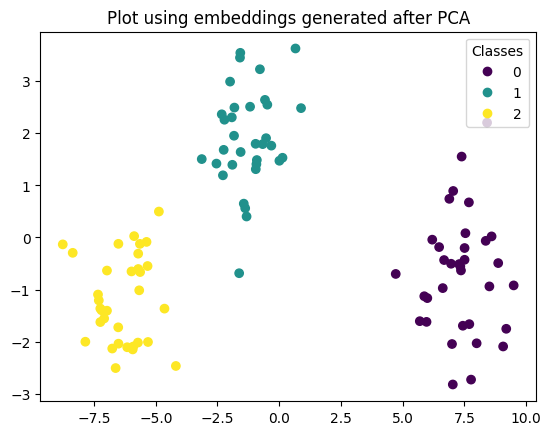

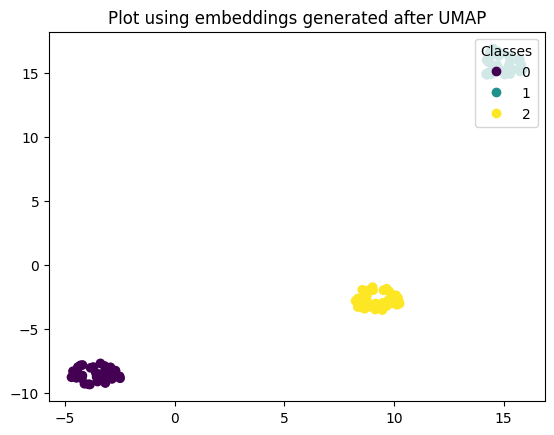

In [56]:
MB = MakeBlobs_Outliers_Visualization(100, 3, 3);
print (MB.X.shape, MB.y.shape)
MB.featurize();
print(MB.X_features.shape)
MB.getEmbedding_PCA();
print(MB.X_embedding_PCA.shape)
MB.getEmbedding_UMAP();
print(MB.X_embedding_UMAP.shape)
MB.visualize(PCA=True, UMAP=True);


[2 1 2 0 2 2 2 0 0 0 2 1 2 1 1 0 1 2 2 2 0 2 0 1 0 0 0 2 0 1 1 2 1 1 0 2 0
 2 1 0 0 1 2 2 0 2 1 0 0 2 1 1 2 2 1 2 2 0 2 0 0 1 1 1 0 0 0 1 2 0 0 1 0 2
 2 1 2 1 0 1 0 1 1 1 1 2 1 1 1 0 2 2 2 0 1 0 1 0 2 0]
[[ 7.36166596 -0.69780195]
 [-1.25093668  1.89685472]
 [-6.33381006 -1.17790725]]


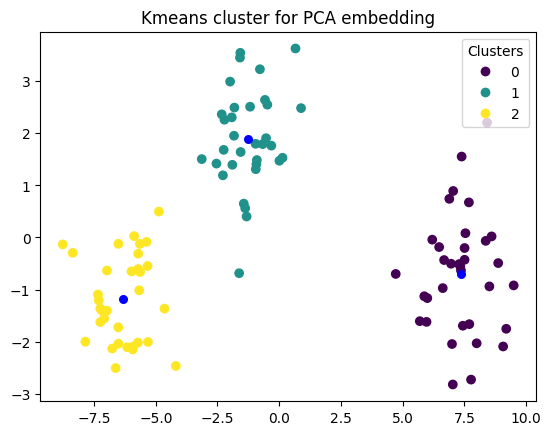

[0.978682068480285, 0.9852538063997307, 0.9788647604055948, 0.9837767828586635, 0.9756685036519019, 0.9402192921593029, 0.9777702587467335, 0.9792990291286167, 0.9999228603983512, 0.9419640506539323, 0.8698894431971392, 0.9368601150180169, 0.9595904562166365, 0.9279333207191259, 0.7207232763292125, 0.8745424347957088, 0.9861963479058151, 0.9736896431473944, 0.8976451563628725, 0.9745365637911021, 0.977915050803828, 0.9293358613393878, 0.9551328156304207, 0.9961523317525408, 0.9694248516589631, 0.9806486289277867, 0.9408135952266931, 0.9813825256350446, 0.9432625334896643, 0.9928343857084159, 0.9866434170608052, 0.9392379749082678, 0.9676506782818086, 0.9680402740148308, 0.9888554680121686, 0.9737809293674057, 0.960403719098078, 0.9021637631051374, 0.9747984538741657, 0.9992769982337083, 0.9891570712131438, 0.9737409931819363, 0.7353667142853961, 0.9500197396976648, 0.9506762125721094, 0.8750636129101856, 0.9022012700230144, 0.9996212760180608, 0.9670579605341448, 0.990256478898541, 0.9

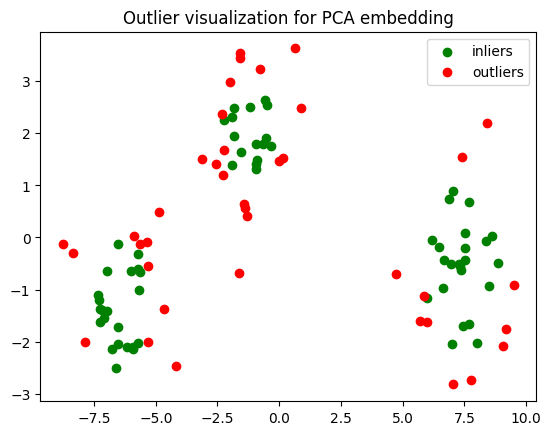

In [57]:

MB.kmeans_clustering(3,emdedding_choice_flag=False)
print(MB.kmeans.labels_)
#print(MB.kmeans.predict(MB.X_embedding_UMAP))
print(MB.kmeans.cluster_centers_)

MB.kmeans_cluster_plot()

MB.goodness_score_kmeans()
print(MB.kmeans_goodness_score)
print(min(MB.kmeans_goodness_score))
print(max(MB.kmeans_goodness_score))

MB.outliers_inliers_plot_kmeans(0.95)

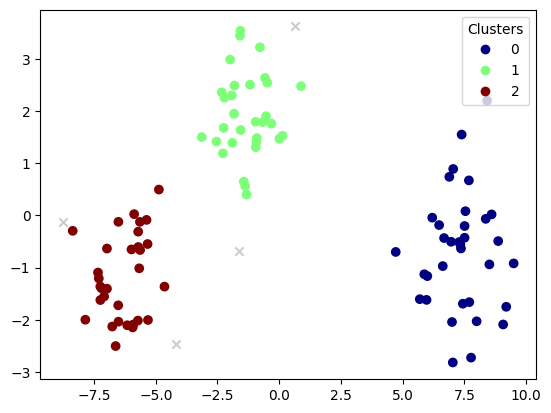

In [58]:
MB.hdbscan_clustering()

#MNIST

In [59]:
!pwd

/Users/abc/Desktop/proj


In [60]:
import idx2numpy

In [61]:
class MNIST_Outliers_Visualization(OutlierVisualization):
  
  def __init__(self):
    


    imagefile = r"Datasets/MNIST/train-images-idx3-ubyte"
    self.X = idx2numpy.convert_from_file(imagefile)

    labelfile = r"Datasets/MNIST/train-labels-idx1-ubyte"
    self.y  = idx2numpy.convert_from_file(labelfile)

    self.num_classes = len(np.unique(self.y))
  
  def featurize(self):
    self.X_features  =  self.X .reshape((len(self.X ), len(self.X [0])*len(self.X [0][0])))
    

  
  def getEmbedding_PCA(self, component_cnt=2):
    if len(self.X_features[0])==2:
      self.X_embedding_PCA =self.X_features;

    else:   

      pca = PCA(n_components=component_cnt)
      self.X_embedding_PCA = pca.fit_transform(self.X_features)



  
  def getEmbedding_UMAP(self):
    reducer = umap.UMAP()
    self.X_embedding_UMAP = reducer.fit_transform(self.X_features)


  def visualize(self, PCA=False, UMAP=True):


    if PCA:
      scatter_classes_mnist = plt.scatter(self.X_embedding_PCA [:, 0], self.X_embedding_PCA [:, 1], c=self.y)
      plt.legend(*scatter_classes_mnist.legend_elements(),
                      loc="upper right", title="Classes")
      plt.title("Plot using embeddings generated after PCA")
      plt.show()

    print()
    if UMAP:
      scatter_classes = plt.scatter(self.X_embedding_UMAP [:, 0], self.X_embedding_UMAP [:, 1], c=self.y)
      plt.legend(*scatter_classes.legend_elements(),
                      loc="upper right", title="Classes")
      plt.title("Plot using embeddings generated after UMAP")
      plt.show()


  def __goodness_score_point(self, cluster_dist_list , cluster_id , n):
    dist_from_assigned_cluster = cluster_dist_list[cluster_id];

    denominator  = sum([(1/a)** (n-1) for a in cluster_dist_list])
    numerator = (1/dist_from_assigned_cluster)** (n-1)

    return numerator / denominator;


  

  def goodness_score_kmeans(self):
    self.kmeans_goodness_score = [self.__goodness_score_point(self.kmeans_dist_from_cluster_centroid[i],\
                                                            self.kmeans.labels_[i] , self.cluster_count ) \
                      for i in list(range(0,len(self.kmeans.labels_)))]



  def kmeans_clustering(self,cluster_cnt=None, emdedding_choice_flag=True):
    
    if cluster_cnt==None:
      self.cluster_count=self.num_classes
    else:
      self.cluster_count=cluster_cnt



    self.embedding_choice = emdedding_choice_flag;

    if emdedding_choice_flag: #use umap embedding 
      self.kmeans= KMeans(n_clusters= self.cluster_count, random_state=0).fit(self.X_embedding_UMAP)
      self.kmeans_dist_from_cluster_centroid= self.kmeans.transform(self.X_embedding_UMAP);


    else:
      self.kmeans= KMeans(n_clusters= self.cluster_count, random_state=0).fit(self.X_embedding_PCA)
      self.kmeans_dist_from_cluster_centroid= self.kmeans.transform(self.X_embedding_PCA);



    
  def kmeans_cluster_plot(self):

    if self.embedding_choice: #use umap embedding 
      scatter_cluster = plt.scatter(self.X_embedding_UMAP[:, 0], self.X_embedding_UMAP[:, 1], c=self.kmeans.labels_)
      plt.scatter(self.kmeans.cluster_centers_[:, 0], \
                  self.kmeans.cluster_centers_[:, 1], s=30, c='blue', label = 'Centroids')
      plt.legend(*scatter_cluster.legend_elements(),loc="upper right", title="Clusters")
      plt.title("Kmeans cluster for UMAP embedding")
      plt.show()
          
          
    else:
      scatter_cluster = plt.scatter(self.X_embedding_PCA[:, 0], self.X_embedding_PCA[:, 1], c=self.kmeans.labels_)
      plt.scatter(self.kmeans.cluster_centers_[:, 0], \
                  self.kmeans.cluster_centers_[:, 1], s=30, c='blue', label = 'Centroids')
      plt.legend(*scatter_cluster.legend_elements(),loc="upper right", title="Clusters")
      plt.title("Kmeans cluster for PCA embedding")
      plt.show()


  def outliers_inliers_plot_kmeans(self, thrh = 0.7):

    goodness_score = np.array(self.kmeans_goodness_score)

    mask_outliers = (goodness_score < thrh) 
    mask_inliers= ~mask_outliers
    if self.embedding_choice: #use umap embedding 
      plt.scatter(self.X_embedding_UMAP[mask_inliers, 0], self.X_embedding_UMAP[mask_inliers, 1], c='g', label='inliers')
      plt.scatter(self.X_embedding_UMAP[mask_outliers, 0], self.X_embedding_UMAP[mask_outliers, 1], c='r', label='outliers')
      plt.legend()
      plt.title("Outlier visualization for UMAP embedding")
      plt.show()

    else:
      plt.scatter(self.X_embedding_PCA[mask_inliers, 0], self.X_embedding_PCA[mask_inliers, 1], c='g', label='inliers')
      plt.scatter(self.X_embedding_PCA[mask_outliers, 0], self.X_embedding_PCA[mask_outliers, 1], c='r', label='outliers')
      plt.legend()
      plt.title("Outlier visualization for PCA embedding")
      plt.show()
      

  def hdbscan_clustering(self,cluster_cnt=None):
    
    if cluster_cnt==None:
      self.cluster_count=self.num_classes
    else:
      self.cluster_count=cluster_cnt


    if self.embedding_choice: 
      hdbscan_clusterer = HDBSCAN_flat(self.X_embedding_UMAP,
                          cluster_selection_method='leaf',
                          n_clusters= self.cluster_count, min_cluster_size=100)
      #EOM = Excess of Mass  method then returns clusters with the best stability over epsilon. Unlike DBSCAN, 
      #this allows to it find clusters of variable densities without having to choose a suitable distance threshold first.
      labels = hdbscan_clusterer.labels_
      proba = hdbscan_clusterer.probabilities_

      scatter_cluster = plt.scatter(self.X_embedding_UMAP[labels>=0, 0], self.X_embedding_UMAP[labels>=0, 1], c=labels[labels>=0],\
                                     cmap=plt.cm.jet)
      plt.legend(*scatter_cluster.legend_elements(),loc="upper right", title="Clusters")
      plt.scatter(self.X_embedding_UMAP[labels<0, 0], self.X_embedding_UMAP[labels<0, 1], c='k', marker='x', alpha=0.4) #aplha is for transparency
      plt.show()
     
    else:
      hdbscan_clusterer = HDBSCAN_flat(self.X_embedding_PCA,
                          cluster_selection_method='leaf',
                          n_clusters= self.cluster_count, min_cluster_size=10)
      labels = hdbscan_clusterer.labels_
      proba = hdbscan_clusterer.probabilities_
      scatter_cluster=plt.scatter(self.X_embedding_PCA[labels>=0, 0], self.X_embedding_PCA[labels>=0, 1], c=labels[labels>=0],  \
                                  cmap=plt.cm.jet)
      plt.legend(*scatter_cluster.legend_elements(),loc="upper right", title="Clusters")
      plt.scatter(self.X_embedding_PCA[labels<0, 0], self.X_embedding_PCA[labels<0, 1], c='k',  marker='x', alpha=0.4)
      plt.show()
      
              


  


(60000, 28, 28) (60000,)
(60000, 784)
(60000, 2)
(60000, 2)


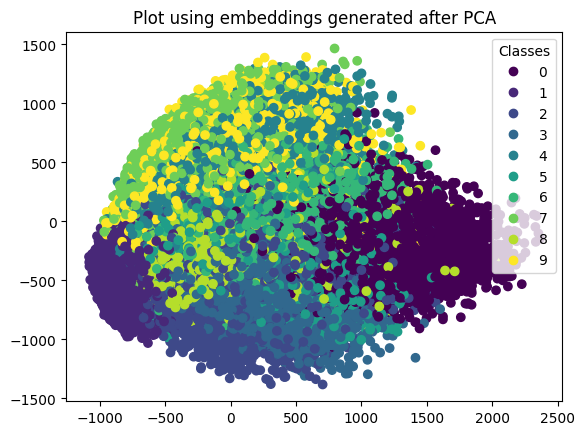

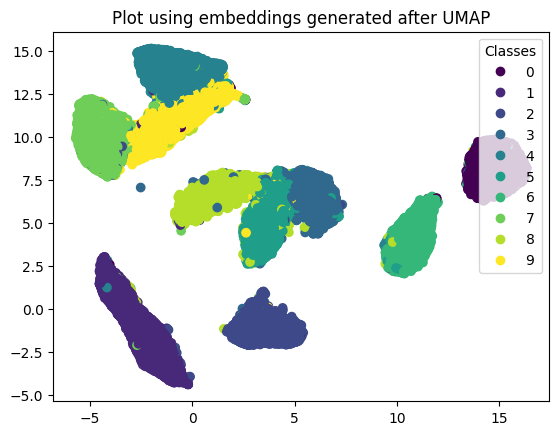

In [62]:
mnist = MNIST_Outliers_Visualization();
print (mnist.X.shape, mnist.y.shape)
mnist.featurize();
print(mnist.X_features.shape)

mnist.getEmbedding_PCA();
print(mnist.X_embedding_PCA.shape)
mnist.getEmbedding_UMAP();
print(mnist.X_embedding_UMAP.shape)
mnist.visualize(PCA=True, UMAP=True);


[8 5 1 ... 8 3 7]
[[ 3.6435728  -1.1402526 ]
 [-0.50281    12.912149  ]
 [ 5.545288    6.4939175 ]
 [10.700279    4.113702  ]
 [-3.5990648   0.86874247]
 [14.783486    8.257086  ]
 [-3.9288297   9.973183  ]
 [ 0.8881531   6.5025473 ]
 [ 3.3639402   4.5695744 ]
 [-1.703352   -2.5683208 ]]


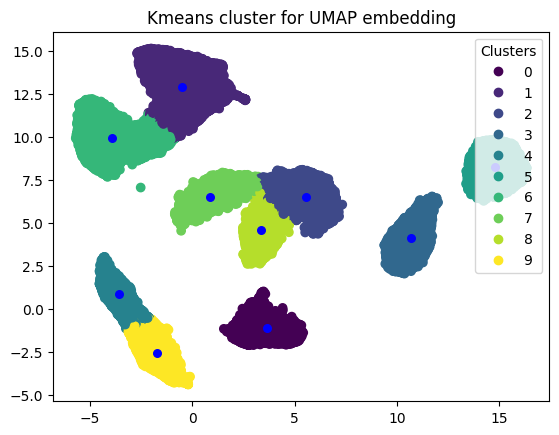

[0.9999985472734078, 0.9999999997172306, 0.9999868454829226, 0.999999721160039, 0.9664075635118089, 0.9999999205372797, 0.9999759931477841, 0.9989718341253866, 0.9999979764394024, 0.9980866453030042, 0.9999552409075149, 0.9990523754704328, 0.9999861530499149, 0.9999999997494158, 0.9999982819293003, 0.9999950715525049, 0.999999999094724, 0.9998997864648039, 0.9999998669972159, 0.9996826955767514, 0.9999532880803738, 0.9999999920977586, 0.9904592062409626, 0.9999995826068769, 0.9999999958566452, 0.9999840462391172, 0.9999999334789672, 0.9999998669216722, 0.9999950653739405, 0.9998176859056525, 0.9997495984208986, 0.9989708155364874, 0.9999999980852396, 0.9998536210879425, 0.9999727049119593, 0.9998846479383325, 0.999999976273934, 0.999995057428389, 0.9999888029993176, 0.9999999999999979, 0.9999984889578134, 0.9999999462570824, 0.999999618354963, 0.9994192150298249, 0.9999842856582641, 0.8049262832256769, 0.9999997305163331, 0.999997736181155, 0.999969428437563, 0.9999938824774056, 0.9999

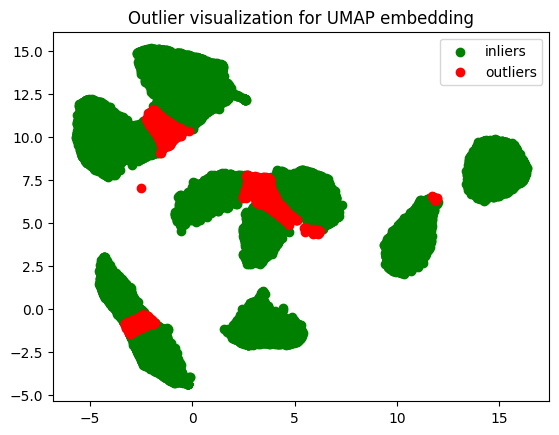

In [63]:

mnist.kmeans_clustering(10,emdedding_choice_flag=True)
print(mnist.kmeans.labels_)
#print(mnist.kmeans.predict(mnist.X_embedding_UMAP))
print(mnist.kmeans.cluster_centers_)

mnist.kmeans_cluster_plot()

mnist.goodness_score_kmeans()
print(mnist.kmeans_goodness_score)
print(min(mnist.kmeans_goodness_score))
print(max(mnist.kmeans_goodness_score))

mnist.outliers_inliers_plot_kmeans(0.95)

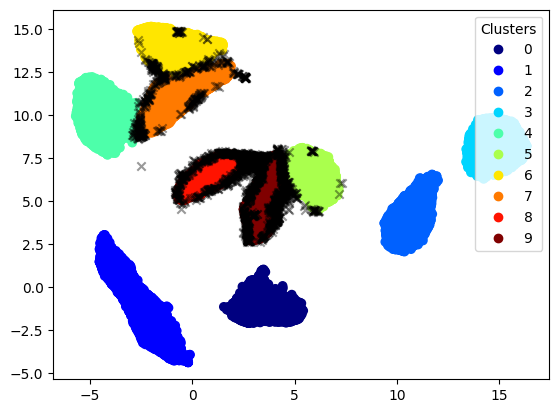

In [64]:
mnist.hdbscan_clustering()

#CIFAR

In [ ]:
#!pip install tensorflow_hub
# !pip install pandas matplotlib datashader bokeh holoviews colorcet scikit-image tornado>=6.2

# !pip install 'umap-learn[plot]'

In [54]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
import ssl
from pathlib import Path
import tensorflow_hub as hub
import umap.plot
import pandas as pd

In [154]:
class CIFAR10_Outliers_Visualization(OutlierVisualization):
  
  def __init__(self,
    folder_path = 'Datasets/CIFAR10/',
    X_train_file = 'X_train.npy',
    Y_train_file = 'Y_train.npy',
    X_test_file = 'X_test.npy',
    Y_test_file = 'Y_test.npy',):

    self.folder_path = folder_path

    X_train_path = Path(self.folder_path + X_train_file)

    if X_train_path.is_file():
        print('Dataset exist in directory | Loading existing files...')

        self.X_train = np.load(self.folder_path + X_train_file)
        self.Y_train = np.load(self.folder_path + Y_train_file)
        self.X_test = np.load(self.folder_path + X_test_file)
        self.Y_test = np.load(self.folder_path + Y_test_file)

    else:
        print('Dataset does not exist in directory | Downloading...')
        ssl._create_default_https_context = ssl._create_unverified_context

        (self.X_train , self.Y_train ), (self.X_test, self.Y_test) = cifar10.load_data()


        np.save(self.folder_path + X_train_file, self.X_train)
        np.save(self.folder_path + Y_train_file, self.Y_train)
        np.save(self.folder_path + X_test_file, self.X_test)
        np.save(self.folder_path + Y_test_file, self.Y_test)


    

  
    self.num_classes = len(np.unique(self.Y_train))
    self.X=self.X_train
    self.y=self.Y_train.reshape(len(self.Y_train))




      


  
  def featurize(self, pre_save_feature_file = '/Features/X_train_features.npy'):

    
    X_train_path = Path(self.folder_path + pre_save_feature_file)

    if X_train_path.is_file():
      print("Loading pre-saved features...")
      self.X_features =np.load(self.folder_path + pre_save_feature_file)
    
    else:
      
      IMG_SIZE=96
      alpha = 0.75

      mobilenet_V2_model= tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3,)),
            hub.KerasLayer(f"https://tfhub.dev/google/imagenet/mobilenet_v2_{alpha*100:03.0f}_{IMG_SIZE}/feature_vector/5",
                        trainable=False),  
            ])
      mobilenet_V2_model.build((None,)+(IMG_SIZE, IMG_SIZE, 3)) 
      print(mobilenet_V2_model.summary()) 
      mobilenet_V2_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
      

      X_preprocessed  = tf.keras.applications.mobilenet_v2.preprocess_input(self.X, data_format=None)
      print("Dimension of preprocessed images " , X_preprocessed.shape)


      X_preprocessed_resized= tf.image.resize(
            X_preprocessed,
            (IMG_SIZE,IMG_SIZE),
            method=tf.image.ResizeMethod.BICUBIC,
            preserve_aspect_ratio=False,
            antialias=False,
            name=None
        )

      print("Dimension of preprocessed - resized images " , X_preprocessed_resized.shape)

      self.X_features = mobilenet_V2_model.predict(X_preprocessed_resized)

      print("Features Generated...")

      np.save(self.folder_path + pre_save_feature_file, self.X_features)



      

  
  def getEmbedding_PCA(self, component_cnt=2):
    if len(self.X_features[0])==2:
      self.X_embedding_PCA =self.X_features;

    else:   

      pca = PCA(n_components=component_cnt)
      self.X_embedding_PCA = pca.fit_transform(self.X_features)



  
  def getEmbedding_UMAP(self):
    reducer = umap.UMAP()
    self.X_embedding_UMAP = reducer.fit_transform(self.X_features)
    self.mapper = umap.UMAP().fit(self.X_features)



  def visualize(self, PCA=False, UMAP=True):


    if PCA:
      scatter_classes_mnist = plt.scatter(self.X_embedding_PCA [:, 0], self.X_embedding_PCA [:, 1], c=self.y)
      plt.legend(*scatter_classes_mnist.legend_elements(),
                      loc="upper right", title="Classes")
      plt.title("Plot using embeddings generated after PCA")
      plt.show()

    print()
    if UMAP:
      scatter_classes = plt.scatter(self.X_embedding_UMAP [:, 0], self.X_embedding_UMAP [:, 1], c=self.y)
      plt.legend(*scatter_classes.legend_elements(),
                      loc="upper right", title="Classes")
      plt.title("Plot using embeddings generated after UMAP")
      plt.show()


  def __goodness_score_point(self, cluster_dist_list , cluster_id , n):
    dist_from_assigned_cluster = cluster_dist_list[cluster_id];

    denominator  = sum([(1/a)** (n-1) for a in cluster_dist_list])
    numerator = (1/dist_from_assigned_cluster)** (n-1)

    return numerator / denominator;


  

  def goodness_score_kmeans(self):
    self.kmeans_goodness_score = [self.__goodness_score_point(self.kmeans_dist_from_cluster_centroid[i],\
                                                            self.kmeans.labels_[i] , self.cluster_count ) \
                      for i in list(range(0,len(self.kmeans.labels_)))]



  def kmeans_clustering(self,cluster_cnt=None, emdedding_choice_flag=True):
    
    if cluster_cnt==None:
      self.cluster_count=self.num_classes
    else:
      self.cluster_count=cluster_cnt



    self.embedding_choice = emdedding_choice_flag;

    if emdedding_choice_flag: #use umap embedding 
      self.kmeans= KMeans(n_clusters= self.cluster_count, random_state=0).fit(self.X_embedding_UMAP)
      self.kmeans_dist_from_cluster_centroid= self.kmeans.transform(self.X_embedding_UMAP);


    else:
      self.kmeans= KMeans(n_clusters= self.cluster_count, random_state=0).fit(self.X_embedding_PCA)
      self.kmeans_dist_from_cluster_centroid= self.kmeans.transform(self.X_embedding_PCA);



    
  def kmeans_cluster_plot(self):

    if self.embedding_choice: #use umap embedding 
      scatter_cluster = plt.scatter(self.X_embedding_UMAP[:, 0], self.X_embedding_UMAP[:, 1], c=self.kmeans.labels_)
      plt.scatter(self.kmeans.cluster_centers_[:, 0], \
                  self.kmeans.cluster_centers_[:, 1], s=30, c='blue', label = 'Centroids')
      plt.legend(*scatter_cluster.legend_elements(),loc="upper right", title="Clusters")
      plt.title("Kmeans cluster for UMAP embedding")
      plt.show()
          
          
    else:
      scatter_cluster = plt.scatter(self.X_embedding_PCA[:, 0], self.X_embedding_PCA[:, 1], c=self.kmeans.labels_)
      plt.scatter(self.kmeans.cluster_centers_[:, 0], \
                  self.kmeans.cluster_centers_[:, 1], s=30, c='blue', label = 'Centroids')
      plt.legend(*scatter_cluster.legend_elements(),loc="upper right", title="Clusters")
      plt.title("Kmeans cluster for PCA embedding")
      plt.show()


  def outliers_inliers_plot_kmeans(self, thrh = 0.7):

    goodness_score = np.array(self.kmeans_goodness_score)

    self.kmeans_mask_outliers = (goodness_score < thrh) 
    self.kmeans_mask_inliers= ~self.kmeans_mask_outliers
    if self.embedding_choice: #use umap embedding 
      plt.scatter(self.X_embedding_UMAP[self.kmeans_mask_inliers, 0], self.X_embedding_UMAP[self.kmeans_mask_inliers, 1], c='g', label='inliers')
      plt.scatter(self.X_embedding_UMAP[self.kmeans_mask_outliers, 0], self.X_embedding_UMAP[self.kmeans_mask_outliers, 1], c='r', label='outliers')
      plt.legend()
      plt.title("Outlier visualization for UMAP embedding")
      plt.show()

    else:
      plt.scatter(self.X_embedding_PCA[self.kmeans_mask_inliers, 0], self.X_embedding_PCA[self.kmeans_mask_inliers, 1], c='g', label='inliers')
      plt.scatter(self.X_embedding_PCA[self.kmeans_mask_outliers, 0], self.X_embedding_PCA[self.kmeans_mask_outliers, 1], c='r', label='outliers')
      plt.legend()
      plt.title("Outlier visualization for PCA embedding")
      plt.show()
      

  def hdbscan_clustering(self,cluster_cnt=None):
    
    if cluster_cnt==None:
      self.cluster_count=self.num_classes
    else:
      self.cluster_count=cluster_cnt


    if self.embedding_choice: 
      self.hdbscan_clusterer = HDBSCAN_flat(self.X_embedding_UMAP,
                          cluster_selection_method='leaf',
                          n_clusters= self.cluster_count, min_cluster_size=100)
      #EOM = Excess of Mass  method then returns clusters with the best stability over epsilon. Unlike DBSCAN, 
      #this allows to it find clusters of variable densities without having to choose a suitable distance threshold first.
      labels = self.hdbscan_clusterer.labels_
      proba = self.hdbscan_clusterer.probabilities_

      scatter_cluster = plt.scatter(self.X_embedding_UMAP[labels>=0, 0], self.X_embedding_UMAP[labels>=0, 1], c=labels[labels>=0],\
                                     cmap=plt.cm.jet)
      plt.legend(*scatter_cluster.legend_elements(),loc="upper right", title="Clusters")
      plt.scatter(self.X_embedding_UMAP[labels<0, 0], self.X_embedding_UMAP[labels<0, 1], c='k', marker='x', alpha=0.4) #aplha is for transparency
      plt.show()
     
    else:
      self.hdbscan_clusterer = HDBSCAN_flat(self.X_embedding_PCA,
                          cluster_selection_method='leaf',
                          n_clusters= self.cluster_count, min_cluster_size=10)
      labels = self.hdbscan_clusterer.labels_
      proba = self.hdbscan_clusterer.probabilities_
      scatter_cluster=plt.scatter(self.X_embedding_PCA[labels>=0, 0], self.X_embedding_PCA[labels>=0, 1], c=labels[labels>=0],  \
                                  cmap=plt.cm.jet)
      plt.legend(*scatter_cluster.legend_elements(),loc="upper right", title="Clusters")
      plt.scatter(self.X_embedding_PCA[labels<0, 0], self.X_embedding_PCA[labels<0, 1], c='k',  marker='x', alpha=0.4)
      plt.show()
      
              
  def Dataset_Visualization_UMAP(self):
    umap.plot.points(self.mapper,labels=self.y,theme='fire')

  def Dataset_Interactive_Visualization_UMAP(self):

    hover_data = pd.DataFrame({'index':np.arange(len(self.y)),
                           'label':self.y})
    hover_data['item'] = hover_data.label.map(
        {
            0:'AIRPLANE',
            1:'AUTOMOBILE',
            2:'BIRD',
            3:'CAT',
            4:'DEER',
            5:'DOG',
            6:'FROG',
            7:'HORSE',
            8:'SHIP',
            9:'TRUCK',
        }
    )


    umap.plot.output_notebook()
    p = umap.plot.interactive(self.mapper, labels=self.y, hover_data=hover_data, point_size=2)
    umap.plot.show(p)

  def HDBSCAN_Cluster_Visualization_UMAP(self):
    umap.plot.points(self.mapper,labels=self.hdbscan_clusterer.labels_,theme='fire')

  def HDBSCAN_Cluster_Interactive_Visualization_UMAP(self):

    hover_data = pd.DataFrame({'index':np.arange(len(self.y)),
                           'label':self.y})
    hover_data['item'] = hover_data.label.map(
        {
            0:'CLUSTER 0',
            1:'CLUSTER 1',
            2:'CLUSTER 2',
            3:'CLUSTER 3',
            4:'CLUSTER 4',
            5:'CLUSTER 5',
            6:'CLUSTER 6',
            7:'CLUSTER 7',
            8:'CLUSTER 8',
            9:'CLUSTER 9',
        }
    )
    umap.plot.output_notebook()
    p = umap.plot.interactive(self.mapper, labels=self.hdbscan_clusterer.labels_, hover_data=hover_data, point_size=2)
    umap.plot.show(p)



  def KMEANS_Cluster_Visualization_UMAP(self):
    umap.plot.points(self.mapper,labels=self.kmeans.labels_,theme='fire')

  def KMEANS_Cluster_Interactive_Visualization_UMAP(self):

    hover_data = pd.DataFrame({'index':np.arange(len(self.y)),
                           'label':self.y})
    hover_data['item'] = hover_data.label.map(
        {
            0:'CLUSTER 0',
            1:'CLUSTER 1',
            2:'CLUSTER 2',
            3:'CLUSTER 3',
            4:'CLUSTER 4',
            5:'CLUSTER 5',
            6:'CLUSTER 6',
            7:'CLUSTER 7',
            8:'CLUSTER 8',
            9:'CLUSTER 9',
        }
    )
    umap.plot.output_notebook()
    p = umap.plot.interactive(self.mapper, labels=self.kmeans.labels_, hover_data=hover_data, point_size=2)
    umap.plot.show(p)


  def OUTLIERS_KMEANS_CLUSTERING(self):
  

    outlier_imgs = self.X[self.kmeans_mask_outliers]
    true_labels = self.y[self.kmeans_mask_outliers]

    print("Count of Outliers : ", len(outlier_imgs))

    width=5
    height=5
    rows = 4
    cols = 4
    axes=[]
    fig=plt.figure()

    for a in range(rows*cols):
        
        axes.append( fig.add_subplot(rows, cols, a+1) )
        subplot_title=("Label:"+  str(true_labels[a]))
        axes[-1].set_title(subplot_title)  
        plt.imshow(outlier_imgs[a])
    fig.tight_layout()    
    plt.show()




  def OUTLIERS_HDBSCAN_CLUSTERING(self):
  

    outlier_imgs = self.X[self.hdbscan_clusterer.labels_<0]
    true_labels = self.y[self.hdbscan_clusterer.labels_<0]

    print("Count of Outliers : ", len(outlier_imgs))

    width=5
    height=5
    rows = 4
    cols = 4
    axes=[]
    fig=plt.figure()

    for a in range(rows*cols):
        
        axes.append( fig.add_subplot(rows, cols, a+1) )
        subplot_title=("Label:"+  str(true_labels[a]))
        axes[-1].set_title(subplot_title)  
        plt.imshow(outlier_imgs[a])
    fig.tight_layout()    
    plt.show()


  




  


Dataset exist in directory | Loading existing files...
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
(50000, 32, 32, 3) (50000,)
Loading pre-saved features...
(50000, 1280)
(50000, 2)
(50000, 2)


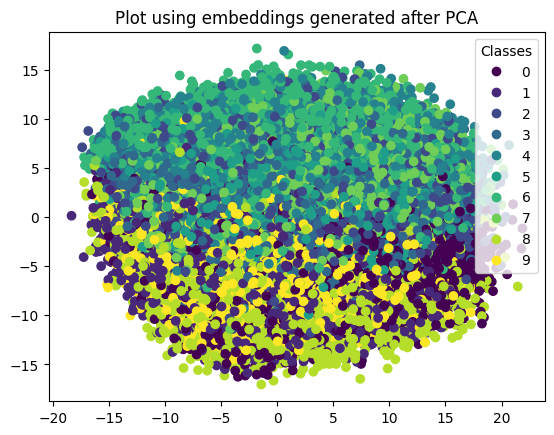

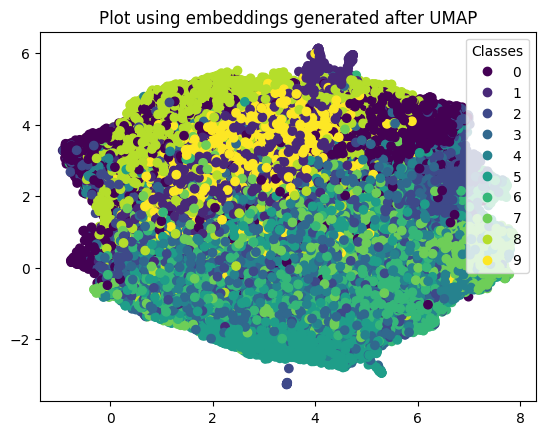

In [155]:
cifar10 = CIFAR10_Outliers_Visualization();
print (cifar10.X_train.shape, cifar10.Y_train.shape)
print (cifar10.X_test.shape, cifar10.Y_test.shape)
print (cifar10.X.shape, cifar10.y.shape)


cifar10.featurize();
print(cifar10.X_features.shape)
cifar10.getEmbedding_PCA();
print(cifar10.X_embedding_PCA.shape)
cifar10.getEmbedding_UMAP();
print(cifar10.X_embedding_UMAP.shape)
cifar10.visualize(PCA=True, UMAP=True);

[1 0 8 ... 2 0 8]
[[ 3.9175808   4.1813464 ]
 [ 2.924148   -0.59476507]
 [ 2.123093    1.9609184 ]
 [ 6.506951    0.56845987]
 [ 0.21983099  2.8260674 ]
 [ 4.9578023  -1.1740397 ]
 [ 4.330684    1.1495812 ]
 [ 6.3261957   3.2575135 ]
 [ 1.8630085   4.0029845 ]
 [ 0.95100427 -0.08896589]]


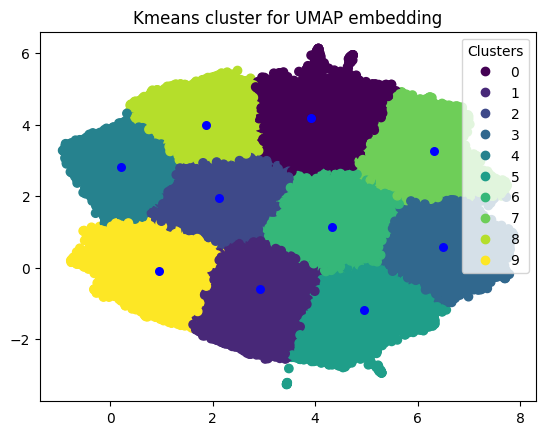

[0.9995394875073732, 0.9999398400748566, 0.9999741528123831, 0.9999427619750298, 0.9975372867873566, 0.9997191623516571, 0.6569021507917078, 0.9999918567857613, 0.9999032993037114, 0.8995175520187594, 0.9999259742227502, 0.9999987912015657, 0.9999999984240056, 0.9999849810220152, 0.9952001297383449, 0.9732127126802146, 0.9984333380951885, 0.9996937014060544, 0.9996800470207691, 0.9963922700203789, 0.9971077143904253, 0.9998223776248577, 0.5911100576267648, 0.8588173929188619, 0.9932722030706188, 0.9999294870380228, 0.9825658259135317, 0.9980571570037677, 0.9998244256299332, 0.9935403427493824, 0.9996341561817896, 0.9994882614431628, 0.994254489698742, 0.9999999993371094, 0.9996286940185143, 0.9623730310054585, 0.9999596493868983, 0.9524139760190151, 0.9999459942317578, 0.9850697321583097, 0.9999279802368315, 0.7180069833429618, 0.986548087952909, 0.9999999998083317, 0.9061547164183268, 0.9999636477230334, 0.9745899428596186, 0.9902610353845193, 0.9887924125176042, 0.9999998842720096, 0

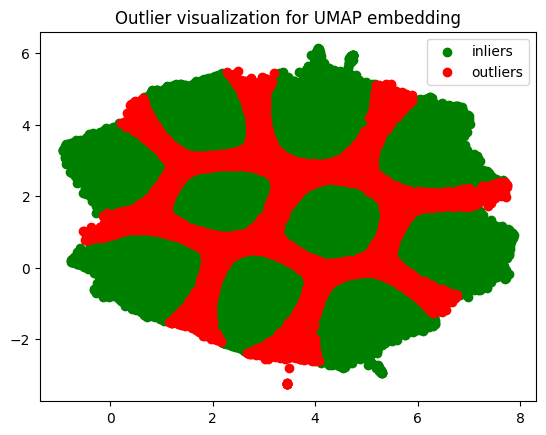

In [156]:
cifar10.kmeans_clustering(10,emdedding_choice_flag=True)
print(cifar10.kmeans.labels_)
#print(cifar10.kmeans.predict(cifar10.X_embedding_UMAP))
print(cifar10.kmeans.cluster_centers_)

cifar10.kmeans_cluster_plot()

cifar10.goodness_score_kmeans()
print(cifar10.kmeans_goodness_score)
print(min(cifar10.kmeans_goodness_score))
print(max(cifar10.kmeans_goodness_score))

cifar10.outliers_inliers_plot_kmeans(0.95)

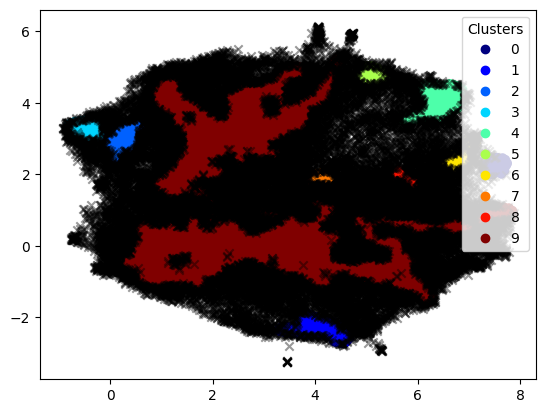

In [157]:
cifar10.hdbscan_clustering()

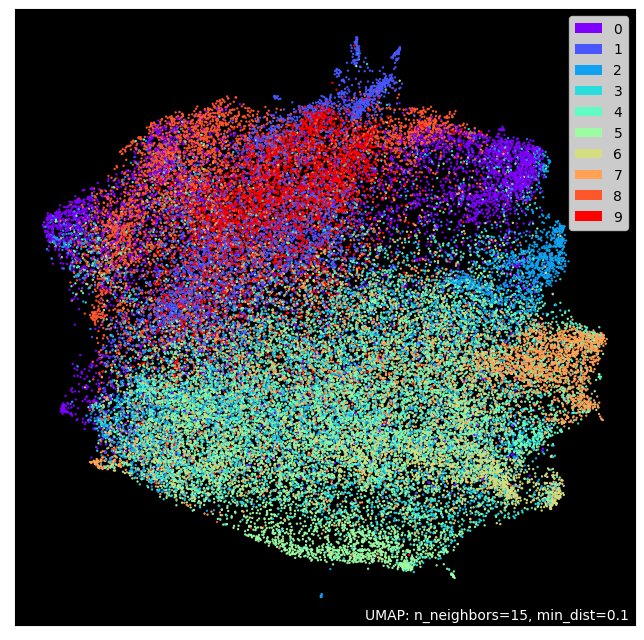

In [158]:
cifar10.Dataset_Visualization_UMAP()

In [159]:
cifar10.Dataset_Interactive_Visualization_UMAP()

Output hidden; open in https://colab.research.google.com to view.

In [160]:
cifar10.HDBSCAN_Cluster_Interactive_Visualization_UMAP()

Output hidden; open in https://colab.research.google.com to view.

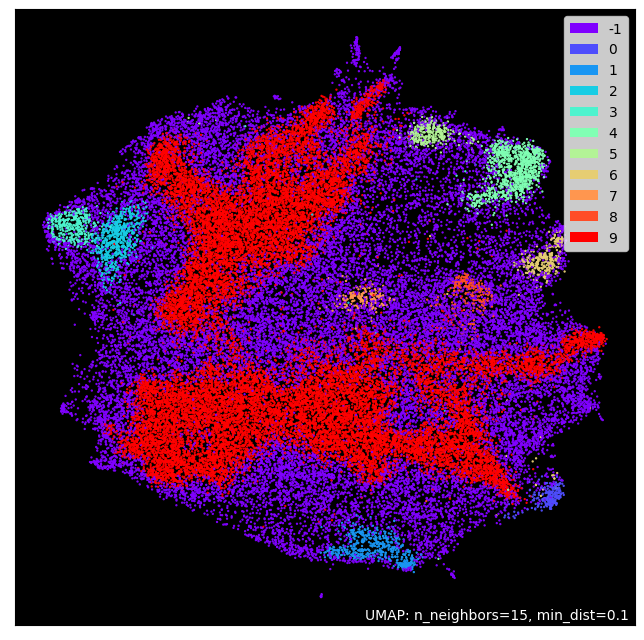

In [161]:
cifar10.HDBSCAN_Cluster_Visualization_UMAP()

In [162]:
cifar10.KMEANS_Cluster_Interactive_Visualization_UMAP()

Output hidden; open in https://colab.research.google.com to view.

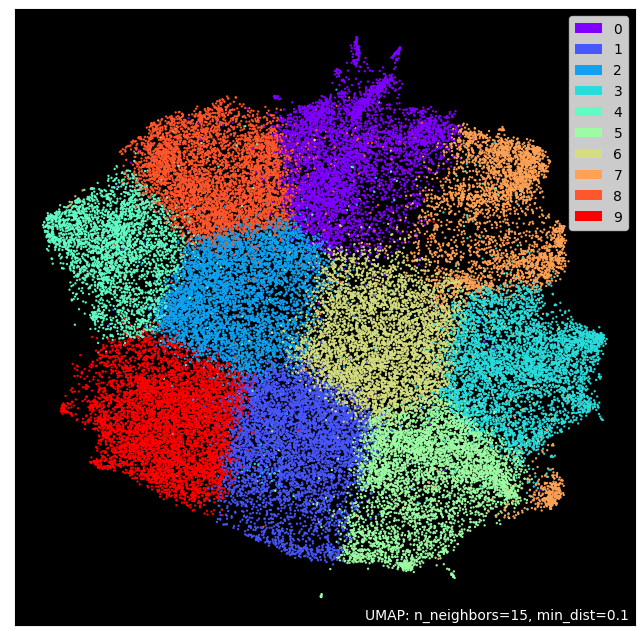

In [163]:
cifar10.KMEANS_Cluster_Visualization_UMAP()

Count of Outliers :  13231


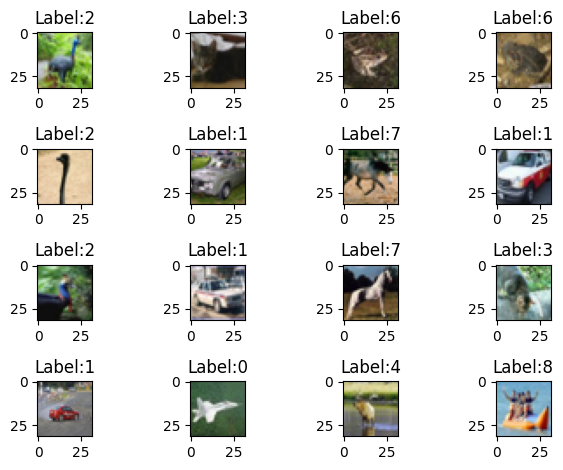

In [164]:
cifar10.OUTLIERS_KMEANS_CLUSTERING()

Count of Outliers :  23612


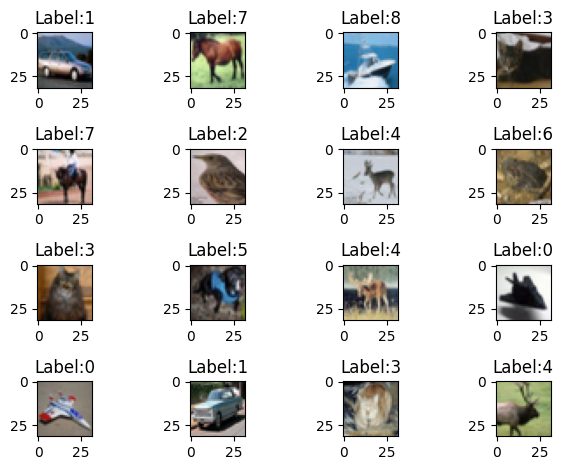

In [165]:
cifar10.OUTLIERS_HDBSCAN_CLUSTERING()